In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
batch_size = 128

In [4]:
train_transform = transforms.Compose([
        transforms.Resize(256),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
train_dir = '../input/facial-age/face_age/face_age'
files = os.listdir(train_dir)
#files = files.remove('face_age')
print(len(files))


99


In [6]:
d = '../input/facial-age/face_age/face_age/110'
print(d.split('/')[-1])
for i in files:
    if i in d.split('/')[-1]:
        print(int(i))

110
110


In [7]:
classes = []

for i in os.listdir(train_dir):
    classes.append(i)
classes = sorted(classes)
print(len(classes))

99


In [8]:
class AgeDataset(Dataset):
    def __init__(self,directory,file_list,transform = None):
        self.directory = directory
        self.file_list = file_list
        self.transform = transform
        self.k = k
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img =  Image.open(os.path.join(self.directory, self.file_list[idx]))
        img = img.convert('RGB')
        img = self.transform(img)
        
        for i in classes:
            if i == self.directory.split('/')[-1]:
                self.label = int(i)
                
            else:
                continue
                
        img = img.numpy()
        return img.astype('float32'), self.label

In [9]:
'''
k=0
working_ds = None
for c in classes:
    directory = os.path.join(train_dir,c)
    file_list = os.listdir(directory)
    if c in directory.split('/')[-1]:
        print(c)
        k=k+1
    new = AgeDataset(directory,file_list,train_transform)
    
    if working_ds == None:
        working_ds = new
    else:
        working_ds = ConcatDataset([working_ds,new])
print(len(working_ds))
print(k)'''


"\nk=0\nworking_ds = None\nfor c in classes:\n    directory = os.path.join(train_dir,c)\n    file_list = os.listdir(directory)\n    if c in directory.split('/')[-1]:\n        print(c)\n        k=k+1\n    new = AgeDataset(directory,file_list,train_transform)\n    \n    if working_ds == None:\n        working_ds = new\n    else:\n        working_ds = ConcatDataset([working_ds,new])\nprint(len(working_ds))\nprint(k)"

In [10]:
working_ds = datasets.ImageFolder(root = os.path.join(train_dir),transform = train_transform)
print(len(working_ds))
train_ds,val_ds = random_split(working_ds,[9000,778])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=128, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_ds,
                                          batch_size=128, 
                                          shuffle=False)

9778


In [11]:
def train_val_split(working_ds):
    val_split = 0.05
    l = float(len(working_ds))
    m = int(val_split*l)
    train_ds,val_ds = random_split(working_ds,[int(l)-m,m])
    return train_ds,val_ds

In [12]:
#train_ds,val_ds = train_val_split(working_ds)

In [13]:
i,l = next(iter(train_loader))
print(l.shape)

torch.Size([128])


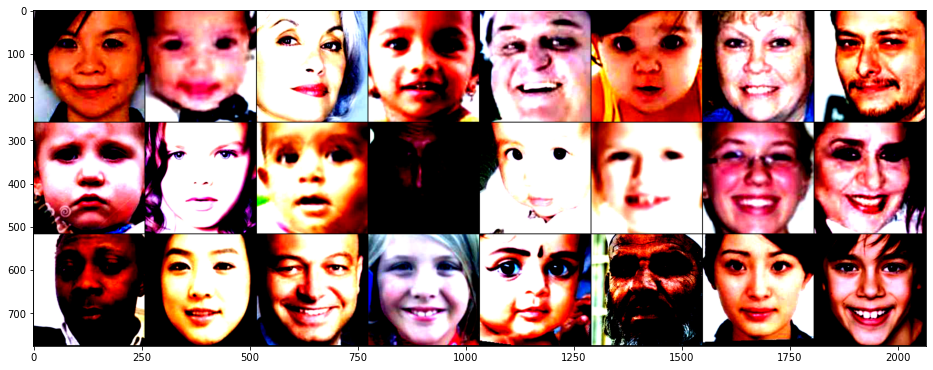

In [14]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [15]:
def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = model(images).float()
      
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [16]:


def train(model, criterion, optimizer,sch,num_epochs):
  for epoch in range(num_epochs): 
      print("Epoch:",epoch+1)
      running_loss = 0.0
      
      for i,data in enumerate(train_loader,0):
          inputs,labels = data
          
          
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          optimizer.zero_grad()
    
          output = model(inputs)
          output = output.to(device)
          loss = criterion(output, labels)
    
          loss.backward()
          optimizer.step()
          
          
          running_loss += loss.item()
    
    
          if i % 50 == 49:    
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 50))
              running_loss = 0.0
      sch.step()  
      print('Epoch:', epoch+1,'LR:', sch.get_last_lr())
      print("EPOCH OVER")
      train_acc = model_eval(train_loader,model)
      with torch.no_grad():
        test_acc = model_eval(val_loader,model)
      print("############################")
      print("Training Accuracy:",train_acc,"Testing Accuracy",test_acc)
      print("############################")
      print("")
  return model
    


In [17]:
vgg16_backbone = models.vgg16(pretrained=True)
i=0
for param in vgg16_backbone.parameters():
    i=i+1
    #param.requires_grad = True
    if(i >=24):
        param.requires_grad = True
    else:
        param.requires_grad = False
#num_ftrs = vgg16_backbone.fc.in_features
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(*list(vgg16_backbone.features.children()))

        self.drop1 = nn.Dropout(0.3)
        #self.drop2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(32768,1024)
        #self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(1024,1)
        self.final = nn.Sigmoid()
    def forward(self,x):
    
        x = self.features(x)

        x = x.view(x.shape[0],32768)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        #x = F.relu(self.fc2(x))
       
        #x = self.drop2(x)
        x = self.fc3(x)
        #x = self.drop1(x)
        #x = F.relu(self.fc4(x))
        x = self.final(x)

        return x       


criterion = nn.CrossEntropyLoss()  
    
vgg_model = VGG16()
vgg_model = vgg_model.to(device)



#optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
print(vgg_model)



VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [18]:
history = []
from tqdm import tqdm
def train(loader, model, optimizer, criterion, scaler):
    loop = tqdm(loader) #For the progress bar
    
    for idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.type(torch.float32).unsqueeze(1).to(device)
        targets = 0.01 + targets/100
        
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #lr.append(get_lr(optimizer))
        loop.set_postfix(loss = loss.item())
        history.append(loss)
        

In [19]:

from tqdm import tqdm
def train1( loader, model, optimizer, criterion, scaler):
        loop = tqdm(loader) #For the progress bar
    
    #for idx, (data, targets) in enumerate(loop):
        data, targets = next(iter(train_loader))
        data = data.to(device)
        targets = targets.float().to(device)
        
        
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        history.append(loss.item())
        loop.set_postfix(loss = loss.item())
        
        

In [20]:
d,l = next(iter(train_loader))
d = d.to(device)
l = l.to(device).unsqueeze(1)
x = vgg_model(d)
print(x.shape)
print(l.shape)

torch.Size([128, 1])
torch.Size([128, 1])


In [21]:
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
sch = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

scaler = torch.cuda.amp.GradScaler()
NUM_EPOCHS = 25
for epoch in range(NUM_EPOCHS):
    print(f"epoch:{epoch+1}/{NUM_EPOCHS}")
    print("LR:",sch.get_last_lr())
    train(train_loader, vgg_model, optimizer, criterion, scaler)
    sch.step()
    print("EPOCH OVER")

  0%|          | 0/71 [00:00<?, ?it/s]

epoch:1/25
LR: [0.0001]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:2/25
LR: [0.0001]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:3/25
LR: [0.0001]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:4/25
LR: [0.0001]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:5/25
LR: [0.0001]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:6/25
LR: [0.0001]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:7/25
LR: [0.0001]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:8/25
LR: [1e-05]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:9/25
LR: [1e-05]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:10/25
LR: [1e-05]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:11/25
LR: [1e-05]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:12/25
LR: [1e-05]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:13/25
LR: [1e-05]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:14/25
LR: [1e-05]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:15/25
LR: [1.0000000000000002e-06]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:16/25
LR: [1.0000000000000002e-06]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:17/25
LR: [1.0000000000000002e-06]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:18/25
LR: [1.0000000000000002e-06]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:19/25
LR: [1.0000000000000002e-06]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:20/25
LR: [1.0000000000000002e-06]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:21/25
LR: [1.0000000000000002e-06]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:22/25
LR: [1.0000000000000002e-07]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:23/25
LR: [1.0000000000000002e-07]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:24/25
LR: [1.0000000000000002e-07]


  0%|          | 0/71 [00:00<?, ?it/s]

EPOCH OVER
epoch:25/25
LR: [1.0000000000000002e-07]


100%|██████████| 71/71 [01:13<00:00,  1.04s/it, loss=0.000524]

EPOCH OVER


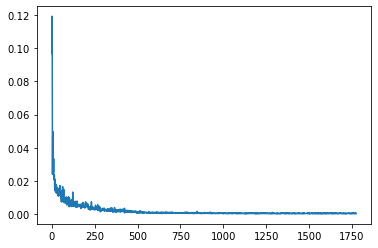

In [22]:
plt.plot(history)
plt.show()

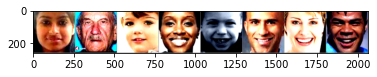

[18, 85, 7, 30, 4, 26, 36, 39]
[33, 88, 4, 30, 1, 29, 51, 37]


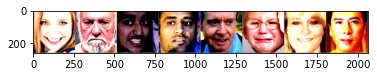

[16, 75, 17, 36, 46, 3, 63, 36]
[14, 78, 23, 31, 57, 56, 59, 38]


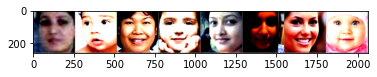

[26, 1, 49, 4, 26, 21, 29, 1]
[28, 1, 23, 1, 26, 28, 23, 0]


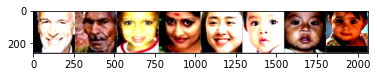

[56, 75, 3, 27, 22, 1, 3, 1]
[52, 54, 4, 18, 11, 0, 0, 8]


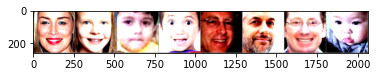

[52, 9, 4, 5, 52, 53, 42, 1]
[57, 8, 7, 7, 56, 54, 45, 0]


In [23]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
i=0
for x,y in val_loader:
    i = i+1
    x=x.cuda()
    y=.01+y.reshape(batch_size,1).cuda().type(torch.float32)/100
    z=vgg_model(x)

    imshow(torchvision.utils.make_grid(x[0:8].cpu()))
    y=(y*100).type(torch.int64)
    z=(z*100).type(torch.int64)
    print(y.reshape(1,batch_size).tolist()[0][:8])
    print(z.reshape(1,batch_size).tolist()[0][:8])
    if(i == 5):
        break
    

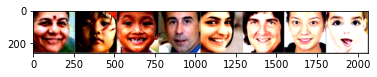

[62, 4, 4, 45, 23, 56, 26, 2]
[63, 5, 2, 44, 17, 56, 21, 0]


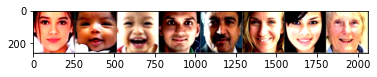

[18, 1, 4, 29, 58, 49, 16, 82]
[16, 0, 4, 26, 60, 40, 19, 80]


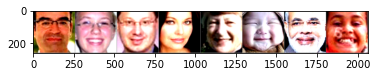

[48, 17, 39, 29, 64, 1, 62, 12]
[46, 19, 40, 28, 63, 3, 64, 11]


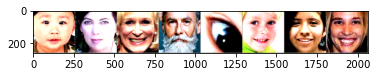

[1, 39, 64, 58, 1, 4, 18, 30]
[1, 35, 67, 59, 0, 5, 16, 31]


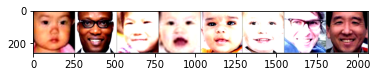

[2, 36, 4, 1, 1, 4, 39, 48]
[0, 36, 3, 0, 1, 2, 39, 39]


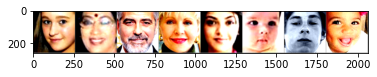

[15, 39, 53, 65, 26, 2, 16, 2]
[13, 43, 56, 65, 25, 0, 19, 3]


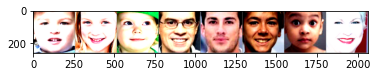

[7, 8, 3, 35, 26, 16, 2, 62]
[1, 10, 0, 36, 26, 17, 1, 64]


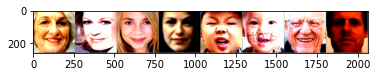

[85, 65, 16, 38, 4, 3, 82, 30]
[84, 64, 14, 38, 2, 0, 81, 26]


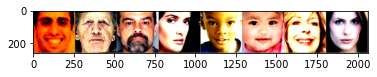

[30, 85, 56, 26, 7, 3, 65, 33]
[37, 83, 57, 25, 1, 0, 62, 32]


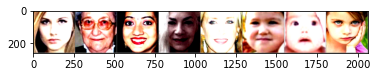

[21, 85, 26, 79, 58, 4, 1, 4]
[25, 88, 27, 68, 62, 5, 0, 3]


In [24]:
i=0
for x,y in train_loader:
    i = i+1
    x=x.cuda()
    y=.01+y.reshape((batch_size,1)).cuda().type(torch.float32)/100
    z=vgg_model(x)

    imshow(torchvision.utils.make_grid(x[0:8].cpu()))
    y=(y*100).type(torch.int64)
    z=(z*100).type(torch.int64)
    print(y.reshape(1,batch_size).tolist()[0][0:8])
    print(z.reshape(1,batch_size).tolist()[0][0:8])
    if(i == 10):
        break